# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [57]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [5]:
# TODO: Implement gradient check function


def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [8]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [9]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [12]:
# TODO Implement co`mbined functi                                                                                                                                                                                                                                                                                               on or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), 
                                                                       np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [13]:
# TODO Extend combined function so it can receive a 2d array with batch of samples

# Test batch_size = 1
batch_size = 1
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

#Test batch_size = 3
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [16]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [17]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [51]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=20, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 858.110902
Epoch 1, loss: 761.156425
Epoch 2, loss: 871.031878
Epoch 3, loss: 1101.972381
Epoch 4, loss: 977.922163
Epoch 5, loss: 829.842983
Epoch 6, loss: 928.218723
Epoch 7, loss: 726.710235
Epoch 8, loss: 832.133250
Epoch 9, loss: 910.636392
Epoch 10, loss: 813.269423
Epoch 11, loss: 828.264079
Epoch 12, loss: 874.969533
Epoch 13, loss: 796.341651
Epoch 14, loss: 927.484314
Epoch 15, loss: 862.182934
Epoch 16, loss: 891.071483
Epoch 17, loss: 946.142308
Epoch 18, loss: 928.550252
Epoch 19, loss: 831.985329


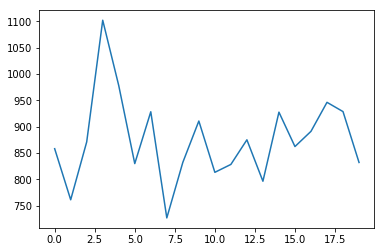

In [52]:
# let's look at the loss history!
plt.plot(loss_history)

In [54]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.216
Epoch 0, loss: 1721.350122
Epoch 1, loss: 1702.753517
Epoch 2, loss: 1640.228561
Epoch 3, loss: 1668.236239
Epoch 4, loss: 1850.056881
Epoch 5, loss: 1755.584963
Epoch 6, loss: 1813.964629
Epoch 7, loss: 1887.788685
Epoch 8, loss: 1671.629782
Epoch 9, loss: 1748.616641
Epoch 10, loss: 1790.753001
Epoch 11, loss: 1858.704184
Epoch 12, loss: 1724.743462
Epoch 13, loss: 1760.954007
Epoch 14, loss: 1960.685329
Epoch 15, loss: 1786.161717
Epoch 16, loss: 1842.615307
Epoch 17, loss: 1866.122996
Epoch 18, loss: 1821.693439
Epoch 19, loss: 2174.371801
Epoch 20, loss: 1927.111070
Epoch 21, loss: 1835.763568
Epoch 22, loss: 2003.824741
Epoch 23, loss: 2004.254644
Epoch 24, loss: 1839.942897
Epoch 25, loss: 2198.599832
Epoch 26, loss: 1941.086456
Epoch 27, loss: 1928.556041
Epoch 28, loss: 2069.161807
Epoch 29, loss: 2075.452939
Epoch 30, loss: 1963.397253
Epoch 31, loss: 1940.695558
Epoch 32, loss: 1914.680473
Epoch 33, loss: 2099.704822
Epoch 34, loss: 2143.860188
Epoch 35, los

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [62]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
reg_strengths = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for learning_rate in learning_rates:
    for reg in reg_strengths:
        clf = linear_classifer.LinearSoftmaxClassifier()
        clf.fit(train_X, train_y, batch_size = batch_size, learning_rate = learning_rate, reg = reg, epochs = num_epochs)
        preds = clf.predict(test_X)
        accuracy = multiclass_accuracy(preds, test_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = clf


        

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 782.419904
Epoch 1, loss: 687.074615
Epoch 2, loss: 769.240492
Epoch 3, loss: 924.274242
Epoch 4, loss: 835.910712
Epoch 5, loss: 733.852019
Epoch 6, loss: 823.664398
Epoch 7, loss: 947.536273
Epoch 8, loss: 766.028569
Epoch 9, loss: 702.275478
Epoch 10, loss: 802.468377
Epoch 11, loss: 746.530561
Epoch 12, loss: 888.998965
Epoch 13, loss: 752.869831
Epoch 14, loss: 760.397102
Epoch 15, loss: 838.274442
Epoch 16, loss: 851.597429
Epoch 17, loss: 699.684691
Epoch 18, loss: 778.627515
Epoch 19, loss: 800.092929
Epoch 20, loss: 756.423315
Epoch 21, loss: 697.528010
Epoch 22, loss: 859.443594
Epoch 23, loss: 1006.650777
Epoch 24, loss: 822.103680
Epoch 25, loss: 892.584651
Epoch 26, loss: 797.025906
Epoch 27, loss: 701.822123
Epoch 28, loss: 666.346963
Epoch 29, loss: 710.262244
Epoch 30, loss: 783.300269
Epoch 31, loss: 927.128713
Epoch 32, loss: 746.636410
Epoch 33, loss: 865.806268
Epoch 34, loss: 922.580165
Epoch 35, loss: 888.528243
Epoch 36, loss: 824.859413
Epoch 37, 

Epoch 101, loss: 730.846773
Epoch 102, loss: 746.173623
Epoch 103, loss: 653.974729
Epoch 104, loss: 730.544965
Epoch 105, loss: 709.949645
Epoch 106, loss: 723.516026
Epoch 107, loss: 687.467693
Epoch 108, loss: 722.150877
Epoch 109, loss: 726.289080
Epoch 110, loss: 639.085797
Epoch 111, loss: 775.220584
Epoch 112, loss: 860.917146
Epoch 113, loss: 693.689755
Epoch 114, loss: 727.848422
Epoch 115, loss: 992.181501
Epoch 116, loss: 749.432324
Epoch 117, loss: 816.398802
Epoch 118, loss: 794.969788
Epoch 119, loss: 811.797913
Epoch 120, loss: 901.747107
Epoch 121, loss: 779.577197
Epoch 122, loss: 658.818440
Epoch 123, loss: 827.494448
Epoch 124, loss: 663.332516
Epoch 125, loss: 786.398070
Epoch 126, loss: 774.222695
Epoch 127, loss: 711.557679
Epoch 128, loss: 964.552106
Epoch 129, loss: 679.796365
Epoch 130, loss: 696.725580
Epoch 131, loss: 847.031783
Epoch 132, loss: 800.253642
Epoch 133, loss: 641.451203
Epoch 134, loss: 841.996249
Epoch 135, loss: 644.044294
Epoch 136, loss: 642

Epoch 198, loss: 602.652430
Epoch 199, loss: 622.947050
Epoch 0, loss: 967.200614
Epoch 1, loss: 747.015708
Epoch 2, loss: 1063.347138
Epoch 3, loss: 789.165237
Epoch 4, loss: 853.558884
Epoch 5, loss: 883.237536
Epoch 6, loss: 773.483256
Epoch 7, loss: 886.662482
Epoch 8, loss: 809.338729
Epoch 9, loss: 734.166902
Epoch 10, loss: 897.075748
Epoch 11, loss: 868.016520
Epoch 12, loss: 801.218331
Epoch 13, loss: 716.541112
Epoch 14, loss: 809.888576
Epoch 15, loss: 823.586967
Epoch 16, loss: 775.440564
Epoch 17, loss: 808.669633
Epoch 18, loss: 816.009310
Epoch 19, loss: 736.832783
Epoch 20, loss: 751.506948
Epoch 21, loss: 826.427174
Epoch 22, loss: 780.899880
Epoch 23, loss: 653.707328
Epoch 24, loss: 729.964422
Epoch 25, loss: 828.354208
Epoch 26, loss: 873.060281
Epoch 27, loss: 740.125776
Epoch 28, loss: 793.479040
Epoch 29, loss: 858.306498
Epoch 30, loss: 804.940584
Epoch 31, loss: 822.908855
Epoch 32, loss: 748.025742
Epoch 33, loss: 807.319852
Epoch 34, loss: 828.566064
Epoch 35

Epoch 99, loss: 638.013644
Epoch 100, loss: 739.436654
Epoch 101, loss: 886.940211
Epoch 102, loss: 661.946047
Epoch 103, loss: 760.338391
Epoch 104, loss: 697.540494
Epoch 105, loss: 740.644973
Epoch 106, loss: 641.571301
Epoch 107, loss: 733.641417
Epoch 108, loss: 738.129530
Epoch 109, loss: 773.767542
Epoch 110, loss: 846.804334
Epoch 111, loss: 807.577519
Epoch 112, loss: 824.208449
Epoch 113, loss: 639.979420
Epoch 114, loss: 879.327369
Epoch 115, loss: 663.993866
Epoch 116, loss: 693.940621
Epoch 117, loss: 741.173669
Epoch 118, loss: 686.740102
Epoch 119, loss: 796.800390
Epoch 120, loss: 687.645247
Epoch 121, loss: 705.843587
Epoch 122, loss: 790.021451
Epoch 123, loss: 655.200623
Epoch 124, loss: 759.948343
Epoch 125, loss: 803.992061
Epoch 126, loss: 703.159910
Epoch 127, loss: 649.831769
Epoch 128, loss: 698.401905
Epoch 129, loss: 711.070709
Epoch 130, loss: 691.838207
Epoch 131, loss: 793.180181
Epoch 132, loss: 928.926221
Epoch 133, loss: 824.701594
Epoch 134, loss: 815.

Epoch 196, loss: 887.164993
Epoch 197, loss: 613.465695
Epoch 198, loss: 628.932736
Epoch 199, loss: 909.899698
Epoch 0, loss: 859.817991
Epoch 1, loss: 1081.921614
Epoch 2, loss: 749.922449
Epoch 3, loss: 811.534249
Epoch 4, loss: 867.190449
Epoch 5, loss: 765.112543
Epoch 6, loss: 1024.631914
Epoch 7, loss: 951.204519
Epoch 8, loss: 779.303790
Epoch 9, loss: 926.361421
Epoch 10, loss: 860.355349
Epoch 11, loss: 806.277901
Epoch 12, loss: 970.335904
Epoch 13, loss: 807.601413
Epoch 14, loss: 806.110762
Epoch 15, loss: 804.710448
Epoch 16, loss: 739.867387
Epoch 17, loss: 840.588444
Epoch 18, loss: 883.376453
Epoch 19, loss: 851.419673
Epoch 20, loss: 896.162293
Epoch 21, loss: 837.210889
Epoch 22, loss: 907.218286
Epoch 23, loss: 766.231077
Epoch 24, loss: 849.474607
Epoch 25, loss: 727.133930
Epoch 26, loss: 944.894887
Epoch 27, loss: 678.652518
Epoch 28, loss: 832.160277
Epoch 29, loss: 708.086178
Epoch 30, loss: 752.601895
Epoch 31, loss: 761.250416
Epoch 32, loss: 852.054726
Epoch

Epoch 97, loss: 637.329282
Epoch 98, loss: 633.633201
Epoch 99, loss: 639.629080
Epoch 100, loss: 636.272808
Epoch 101, loss: 644.063186
Epoch 102, loss: 620.751974
Epoch 103, loss: 625.481409
Epoch 104, loss: 609.130119
Epoch 105, loss: 606.857321
Epoch 106, loss: 624.546745
Epoch 107, loss: 646.612042
Epoch 108, loss: 638.094381
Epoch 109, loss: 616.705444
Epoch 110, loss: 625.592131
Epoch 111, loss: 651.746381
Epoch 112, loss: 620.756644
Epoch 113, loss: 628.554847
Epoch 114, loss: 643.155461
Epoch 115, loss: 603.767276
Epoch 116, loss: 628.714614
Epoch 117, loss: 616.967653
Epoch 118, loss: 612.462209
Epoch 119, loss: 618.809229
Epoch 120, loss: 634.858820
Epoch 121, loss: 634.817871
Epoch 122, loss: 614.608585
Epoch 123, loss: 638.625775
Epoch 124, loss: 625.998926
Epoch 125, loss: 617.927015
Epoch 126, loss: 631.822428
Epoch 127, loss: 632.902748
Epoch 128, loss: 610.516676
Epoch 129, loss: 648.065634
Epoch 130, loss: 633.618372
Epoch 131, loss: 623.674333
Epoch 132, loss: 627.68

Epoch 194, loss: 615.659711
Epoch 195, loss: 632.398889
Epoch 196, loss: 626.374369
Epoch 197, loss: 634.893383
Epoch 198, loss: 610.569314
Epoch 199, loss: 632.303418
Epoch 0, loss: 690.982391
Epoch 1, loss: 681.925218
Epoch 2, loss: 676.987699
Epoch 3, loss: 668.752157
Epoch 4, loss: 667.728497
Epoch 5, loss: 668.021402
Epoch 6, loss: 662.223789
Epoch 7, loss: 653.303158
Epoch 8, loss: 650.067889
Epoch 9, loss: 660.917007
Epoch 10, loss: 663.047822
Epoch 11, loss: 658.511441
Epoch 12, loss: 662.587361
Epoch 13, loss: 647.011699
Epoch 14, loss: 656.265092
Epoch 15, loss: 653.859264
Epoch 16, loss: 650.698208
Epoch 17, loss: 654.278144
Epoch 18, loss: 643.133185
Epoch 19, loss: 641.792474
Epoch 20, loss: 644.255530
Epoch 21, loss: 652.430406
Epoch 22, loss: 644.551272
Epoch 23, loss: 641.289667
Epoch 24, loss: 657.591369
Epoch 25, loss: 640.605409
Epoch 26, loss: 640.571198
Epoch 27, loss: 664.027742
Epoch 28, loss: 646.814736
Epoch 29, loss: 635.990614
Epoch 30, loss: 642.150763
Epoch

Epoch 95, loss: 641.064068
Epoch 96, loss: 624.959990
Epoch 97, loss: 624.908492
Epoch 98, loss: 621.731792
Epoch 99, loss: 633.114079
Epoch 100, loss: 629.760921
Epoch 101, loss: 635.365083
Epoch 102, loss: 641.165317
Epoch 103, loss: 644.576641
Epoch 104, loss: 629.686986
Epoch 105, loss: 631.059382
Epoch 106, loss: 633.982933
Epoch 107, loss: 634.716324
Epoch 108, loss: 636.552114
Epoch 109, loss: 626.734804
Epoch 110, loss: 655.681712
Epoch 111, loss: 622.349602
Epoch 112, loss: 620.489424
Epoch 113, loss: 611.221042
Epoch 114, loss: 618.767963
Epoch 115, loss: 632.599607
Epoch 116, loss: 631.117421
Epoch 117, loss: 643.181996
Epoch 118, loss: 641.732494
Epoch 119, loss: 619.304660
Epoch 120, loss: 635.235979
Epoch 121, loss: 621.110654
Epoch 122, loss: 634.259286
Epoch 123, loss: 624.688828
Epoch 124, loss: 623.565216
Epoch 125, loss: 611.585206
Epoch 126, loss: 632.179904
Epoch 127, loss: 618.941950
Epoch 128, loss: 627.296233
Epoch 129, loss: 621.252375
Epoch 130, loss: 630.6728

Epoch 193, loss: 611.791664
Epoch 194, loss: 611.050263
Epoch 195, loss: 624.854233
Epoch 196, loss: 610.395030
Epoch 197, loss: 630.970260
Epoch 198, loss: 632.989155
Epoch 199, loss: 620.537459
Epoch 0, loss: 684.377868
Epoch 1, loss: 678.030877
Epoch 2, loss: 677.679439
Epoch 3, loss: 673.267304
Epoch 4, loss: 672.320226
Epoch 5, loss: 668.004003
Epoch 6, loss: 662.916511
Epoch 7, loss: 661.631784
Epoch 8, loss: 662.920561
Epoch 9, loss: 654.576164
Epoch 10, loss: 665.636206
Epoch 11, loss: 646.128368
Epoch 12, loss: 657.722662
Epoch 13, loss: 650.231801
Epoch 14, loss: 656.841855
Epoch 15, loss: 647.863165
Epoch 16, loss: 664.804736
Epoch 17, loss: 665.364312
Epoch 18, loss: 647.627280
Epoch 19, loss: 650.578121
Epoch 20, loss: 651.036249
Epoch 21, loss: 638.329569
Epoch 22, loss: 647.703926
Epoch 23, loss: 637.681161
Epoch 24, loss: 643.838330
Epoch 25, loss: 660.023875
Epoch 26, loss: 650.891373
Epoch 27, loss: 651.537219
Epoch 28, loss: 639.789987
Epoch 29, loss: 626.355079
Epoc

Epoch 94, loss: 621.172745
Epoch 95, loss: 619.036461
Epoch 96, loss: 624.519422
Epoch 97, loss: 623.445158
Epoch 98, loss: 626.136655
Epoch 99, loss: 634.756723
Epoch 100, loss: 629.323012
Epoch 101, loss: 643.116308
Epoch 102, loss: 640.891993
Epoch 103, loss: 642.463350
Epoch 104, loss: 617.479670
Epoch 105, loss: 608.672977
Epoch 106, loss: 638.985309
Epoch 107, loss: 623.332403
Epoch 108, loss: 634.274381
Epoch 109, loss: 630.494490
Epoch 110, loss: 628.935901
Epoch 111, loss: 621.880157
Epoch 112, loss: 640.283598
Epoch 113, loss: 628.703089
Epoch 114, loss: 612.809663
Epoch 115, loss: 606.159335
Epoch 116, loss: 625.329465
Epoch 117, loss: 622.014382
Epoch 118, loss: 615.976060
Epoch 119, loss: 642.053219
Epoch 120, loss: 630.749426
Epoch 121, loss: 645.535968
Epoch 122, loss: 613.982455
Epoch 123, loss: 616.855959
Epoch 124, loss: 639.442438
Epoch 125, loss: 624.973097
Epoch 126, loss: 629.421424
Epoch 127, loss: 618.878533
Epoch 128, loss: 600.405695
Epoch 129, loss: 633.43583

Epoch 191, loss: 650.224753
Epoch 192, loss: 628.204324
Epoch 193, loss: 647.777271
Epoch 194, loss: 649.987853
Epoch 195, loss: 638.218967
Epoch 196, loss: 664.420448
Epoch 197, loss: 653.089294
Epoch 198, loss: 647.864471
Epoch 199, loss: 653.093473
Epoch 0, loss: 690.486283
Epoch 1, loss: 690.404894
Epoch 2, loss: 690.271690
Epoch 3, loss: 686.896566
Epoch 4, loss: 686.856975
Epoch 5, loss: 686.141280
Epoch 6, loss: 685.655632
Epoch 7, loss: 685.037943
Epoch 8, loss: 684.400679
Epoch 9, loss: 684.343981
Epoch 10, loss: 684.297633
Epoch 11, loss: 683.420728
Epoch 12, loss: 682.475035
Epoch 13, loss: 681.481174
Epoch 14, loss: 683.564855
Epoch 15, loss: 682.374940
Epoch 16, loss: 683.139209
Epoch 17, loss: 680.156075
Epoch 18, loss: 679.062036
Epoch 19, loss: 680.155095
Epoch 20, loss: 680.505631
Epoch 21, loss: 676.450246
Epoch 22, loss: 678.071499
Epoch 23, loss: 679.956165
Epoch 24, loss: 674.475987
Epoch 25, loss: 673.229610
Epoch 26, loss: 673.825157
Epoch 27, loss: 675.297310
Ep

Epoch 92, loss: 659.341410
Epoch 93, loss: 653.234974
Epoch 94, loss: 655.551868
Epoch 95, loss: 649.358591
Epoch 96, loss: 662.596182
Epoch 97, loss: 662.132845
Epoch 98, loss: 653.987997
Epoch 99, loss: 660.518842
Epoch 100, loss: 655.317085
Epoch 101, loss: 654.339036
Epoch 102, loss: 657.579149
Epoch 103, loss: 661.955502
Epoch 104, loss: 655.963439
Epoch 105, loss: 653.980416
Epoch 106, loss: 659.549019
Epoch 107, loss: 655.033152
Epoch 108, loss: 660.680921
Epoch 109, loss: 655.446649
Epoch 110, loss: 650.285716
Epoch 111, loss: 648.216957
Epoch 112, loss: 646.519184
Epoch 113, loss: 658.491921
Epoch 114, loss: 657.276011
Epoch 115, loss: 658.662512
Epoch 116, loss: 646.008168
Epoch 117, loss: 643.325512
Epoch 118, loss: 655.124527
Epoch 119, loss: 656.789778
Epoch 120, loss: 660.759386
Epoch 121, loss: 659.636217
Epoch 122, loss: 656.783578
Epoch 123, loss: 657.638704
Epoch 124, loss: 656.409535
Epoch 125, loss: 642.980278
Epoch 126, loss: 646.434616
Epoch 127, loss: 662.256950


Epoch 189, loss: 651.285687
Epoch 190, loss: 638.124645
Epoch 191, loss: 643.240118
Epoch 192, loss: 648.092936
Epoch 193, loss: 643.115824
Epoch 194, loss: 645.419778
Epoch 195, loss: 651.821071
Epoch 196, loss: 644.093496
Epoch 197, loss: 652.911896
Epoch 198, loss: 654.165870
Epoch 199, loss: 639.965172
Epoch 0, loss: 689.675896
Epoch 1, loss: 689.636752
Epoch 2, loss: 690.474377
Epoch 3, loss: 687.582789
Epoch 4, loss: 687.114502
Epoch 5, loss: 688.313399
Epoch 6, loss: 685.574844
Epoch 7, loss: 685.889663
Epoch 8, loss: 687.884766
Epoch 9, loss: 683.707100
Epoch 10, loss: 683.920639
Epoch 11, loss: 684.060615
Epoch 12, loss: 685.002520
Epoch 13, loss: 684.384696
Epoch 14, loss: 679.825757
Epoch 15, loss: 682.888609
Epoch 16, loss: 681.274630
Epoch 17, loss: 676.614521
Epoch 18, loss: 684.049478
Epoch 19, loss: 676.265220
Epoch 20, loss: 680.069744
Epoch 21, loss: 675.364832
Epoch 22, loss: 673.960994
Epoch 23, loss: 675.865535
Epoch 24, loss: 677.843917
Epoch 25, loss: 676.401656


Epoch 90, loss: 660.831219
Epoch 91, loss: 651.490042
Epoch 92, loss: 654.766257
Epoch 93, loss: 665.025127
Epoch 94, loss: 654.612072
Epoch 95, loss: 664.819151
Epoch 96, loss: 660.162320
Epoch 97, loss: 657.273315
Epoch 98, loss: 663.906445
Epoch 99, loss: 651.353184
Epoch 100, loss: 657.342570
Epoch 101, loss: 653.068725
Epoch 102, loss: 655.770807
Epoch 103, loss: 657.845194
Epoch 104, loss: 653.957246
Epoch 105, loss: 650.906267
Epoch 106, loss: 658.617621
Epoch 107, loss: 652.769911
Epoch 108, loss: 659.213722
Epoch 109, loss: 652.618965
Epoch 110, loss: 664.817681
Epoch 111, loss: 660.664440
Epoch 112, loss: 662.109790
Epoch 113, loss: 657.886779
Epoch 114, loss: 663.432064
Epoch 115, loss: 648.763166
Epoch 116, loss: 655.618845
Epoch 117, loss: 652.421679
Epoch 118, loss: 655.203350
Epoch 119, loss: 649.024033
Epoch 120, loss: 652.546676
Epoch 121, loss: 647.461297
Epoch 122, loss: 655.199692
Epoch 123, loss: 656.011454
Epoch 124, loss: 656.179638
Epoch 125, loss: 642.081135
Ep

Epoch 188, loss: 654.124622
Epoch 189, loss: 647.253349
Epoch 190, loss: 650.021394
Epoch 191, loss: 651.690801
Epoch 192, loss: 648.104082
Epoch 193, loss: 650.674687
Epoch 194, loss: 645.066201
Epoch 195, loss: 654.508121
Epoch 196, loss: 647.358283
Epoch 197, loss: 645.484572
Epoch 198, loss: 645.580254
Epoch 199, loss: 641.394892
Epoch 0, loss: 690.845970
Epoch 1, loss: 690.528253
Epoch 2, loss: 690.632017
Epoch 3, loss: 690.346277
Epoch 4, loss: 690.090726
Epoch 5, loss: 689.849653
Epoch 6, loss: 689.546219
Epoch 7, loss: 689.725158
Epoch 8, loss: 690.286749
Epoch 9, loss: 689.329946
Epoch 10, loss: 690.475738
Epoch 11, loss: 689.745955
Epoch 12, loss: 690.375669
Epoch 13, loss: 688.670525
Epoch 14, loss: 689.345415
Epoch 15, loss: 689.137047
Epoch 16, loss: 688.487937
Epoch 17, loss: 690.018072
Epoch 18, loss: 689.653395
Epoch 19, loss: 688.994747
Epoch 20, loss: 688.047137
Epoch 21, loss: 688.265259
Epoch 22, loss: 689.706773
Epoch 23, loss: 689.181204
Epoch 24, loss: 688.836630

Epoch 90, loss: 684.780108
Epoch 91, loss: 685.482343
Epoch 92, loss: 682.052512
Epoch 93, loss: 687.601661
Epoch 94, loss: 681.841853
Epoch 95, loss: 683.943869
Epoch 96, loss: 685.430637
Epoch 97, loss: 685.698511
Epoch 98, loss: 681.885442
Epoch 99, loss: 682.608227
Epoch 100, loss: 684.489094
Epoch 101, loss: 682.939142
Epoch 102, loss: 684.421995
Epoch 103, loss: 683.274948
Epoch 104, loss: 682.894549
Epoch 105, loss: 684.535357
Epoch 106, loss: 684.435846
Epoch 107, loss: 683.785283
Epoch 108, loss: 682.044658
Epoch 109, loss: 682.402707
Epoch 110, loss: 687.045916
Epoch 111, loss: 683.933791
Epoch 112, loss: 682.978080
Epoch 113, loss: 683.076547
Epoch 114, loss: 683.831751
Epoch 115, loss: 684.537144
Epoch 116, loss: 684.431126
Epoch 117, loss: 682.547723
Epoch 118, loss: 680.085995
Epoch 119, loss: 681.004475
Epoch 120, loss: 681.795793
Epoch 121, loss: 681.597488
Epoch 122, loss: 683.702832
Epoch 123, loss: 681.285179
Epoch 124, loss: 684.271832
Epoch 125, loss: 684.350578
Ep

Epoch 187, loss: 680.718957
Epoch 188, loss: 680.718715
Epoch 189, loss: 681.569499
Epoch 190, loss: 678.755494
Epoch 191, loss: 677.896098
Epoch 192, loss: 676.493889
Epoch 193, loss: 678.994047
Epoch 194, loss: 676.049579
Epoch 195, loss: 678.156529
Epoch 196, loss: 682.670640
Epoch 197, loss: 681.270416
Epoch 198, loss: 677.895353
Epoch 199, loss: 679.029770
Epoch 0, loss: 690.971769
Epoch 1, loss: 690.632249
Epoch 2, loss: 690.489295
Epoch 3, loss: 690.513013
Epoch 4, loss: 690.364397
Epoch 5, loss: 690.160438
Epoch 6, loss: 690.444053
Epoch 7, loss: 690.143976
Epoch 8, loss: 689.767995
Epoch 9, loss: 690.229616
Epoch 10, loss: 689.878599
Epoch 11, loss: 689.918232
Epoch 12, loss: 689.444797
Epoch 13, loss: 689.663538
Epoch 14, loss: 689.508863
Epoch 15, loss: 689.419399
Epoch 16, loss: 689.852258
Epoch 17, loss: 690.256606
Epoch 18, loss: 689.811429
Epoch 19, loss: 689.104384
Epoch 20, loss: 689.118365
Epoch 21, loss: 688.646513
Epoch 22, loss: 688.901977
Epoch 23, loss: 688.52471

Epoch 87, loss: 683.809702
Epoch 88, loss: 685.635093
Epoch 89, loss: 682.717404
Epoch 90, loss: 686.296047
Epoch 91, loss: 686.570301
Epoch 92, loss: 682.206174
Epoch 93, loss: 682.692716
Epoch 94, loss: 682.999103
Epoch 95, loss: 685.060898
Epoch 96, loss: 684.178618
Epoch 97, loss: 681.382691
Epoch 98, loss: 684.831601
Epoch 99, loss: 685.438374
Epoch 100, loss: 685.687927
Epoch 101, loss: 684.272727
Epoch 102, loss: 685.109240
Epoch 103, loss: 682.669788
Epoch 104, loss: 685.248311
Epoch 105, loss: 682.245363
Epoch 106, loss: 686.948528
Epoch 107, loss: 681.312822
Epoch 108, loss: 684.042452
Epoch 109, loss: 682.332378
Epoch 110, loss: 682.692376
Epoch 111, loss: 682.398641
Epoch 112, loss: 683.453279
Epoch 113, loss: 683.349412
Epoch 114, loss: 682.740976
Epoch 115, loss: 682.463408
Epoch 116, loss: 685.140989
Epoch 117, loss: 681.633567
Epoch 118, loss: 684.329021
Epoch 119, loss: 682.866692
Epoch 120, loss: 682.531838
Epoch 121, loss: 681.948276
Epoch 122, loss: 682.477484
Epoch

Epoch 184, loss: 681.469244
Epoch 185, loss: 682.235965
Epoch 186, loss: 677.060976
Epoch 187, loss: 680.638166
Epoch 188, loss: 680.138263
Epoch 189, loss: 680.972959
Epoch 190, loss: 681.358342
Epoch 191, loss: 679.684733
Epoch 192, loss: 675.881461
Epoch 193, loss: 680.928425
Epoch 194, loss: 679.514069
Epoch 195, loss: 682.752549
Epoch 196, loss: 681.834619
Epoch 197, loss: 682.124104
Epoch 198, loss: 679.064200
Epoch 199, loss: 680.259467
Epoch 0, loss: 690.601114
Epoch 1, loss: 690.732907
Epoch 2, loss: 690.805533
Epoch 3, loss: 690.488742
Epoch 4, loss: 690.209660
Epoch 5, loss: 690.288837
Epoch 6, loss: 690.276830
Epoch 7, loss: 689.891753
Epoch 8, loss: 690.364533
Epoch 9, loss: 690.687239
Epoch 10, loss: 688.821652
Epoch 11, loss: 689.588578
Epoch 12, loss: 690.056541
Epoch 13, loss: 689.834626
Epoch 14, loss: 689.752297
Epoch 15, loss: 689.328531
Epoch 16, loss: 689.432148
Epoch 17, loss: 688.799597
Epoch 18, loss: 689.551393
Epoch 19, loss: 689.074860
Epoch 20, loss: 689.07

Epoch 84, loss: 689.842007
Epoch 85, loss: 689.756804
Epoch 86, loss: 689.646290
Epoch 87, loss: 689.988008
Epoch 88, loss: 689.409709
Epoch 89, loss: 689.836341
Epoch 90, loss: 690.080828
Epoch 91, loss: 690.270486
Epoch 92, loss: 690.386532
Epoch 93, loss: 689.420828
Epoch 94, loss: 689.617308
Epoch 95, loss: 690.130245
Epoch 96, loss: 689.612258
Epoch 97, loss: 689.920921
Epoch 98, loss: 689.606170
Epoch 99, loss: 689.836978
Epoch 100, loss: 689.960143
Epoch 101, loss: 689.918763
Epoch 102, loss: 689.959860
Epoch 103, loss: 689.161733
Epoch 104, loss: 689.991849
Epoch 105, loss: 689.971784
Epoch 106, loss: 690.797686
Epoch 107, loss: 689.199844
Epoch 108, loss: 689.819611
Epoch 109, loss: 690.249555
Epoch 110, loss: 689.411577
Epoch 111, loss: 689.615076
Epoch 112, loss: 689.925360
Epoch 113, loss: 689.393693
Epoch 114, loss: 689.527570
Epoch 115, loss: 689.804273
Epoch 116, loss: 689.943505
Epoch 117, loss: 689.809880
Epoch 118, loss: 689.872602
Epoch 119, loss: 690.335871
Epoch 12

Epoch 182, loss: 689.260360
Epoch 183, loss: 689.023548
Epoch 184, loss: 689.488305
Epoch 185, loss: 688.355111
Epoch 186, loss: 688.524065
Epoch 187, loss: 689.237795
Epoch 188, loss: 690.539636
Epoch 189, loss: 689.247796
Epoch 190, loss: 688.733516
Epoch 191, loss: 688.814458
Epoch 192, loss: 689.320716
Epoch 193, loss: 689.780570
Epoch 194, loss: 690.091197
Epoch 195, loss: 689.969552
Epoch 196, loss: 689.519964
Epoch 197, loss: 689.509819
Epoch 198, loss: 689.418090
Epoch 199, loss: 689.518029
Epoch 0, loss: 690.829353
Epoch 1, loss: 690.988668
Epoch 2, loss: 690.450909
Epoch 3, loss: 690.850411
Epoch 4, loss: 690.930760
Epoch 5, loss: 690.956842
Epoch 6, loss: 690.714062
Epoch 7, loss: 690.939565
Epoch 8, loss: 690.417838
Epoch 9, loss: 690.854719
Epoch 10, loss: 690.831743
Epoch 11, loss: 690.862039
Epoch 12, loss: 690.542337
Epoch 13, loss: 690.813428
Epoch 14, loss: 690.989691
Epoch 15, loss: 690.399039
Epoch 16, loss: 690.543547
Epoch 17, loss: 690.438634
Epoch 18, loss: 690.

Epoch 82, loss: 690.396565
Epoch 83, loss: 690.736301
Epoch 84, loss: 689.348413
Epoch 85, loss: 689.396173
Epoch 86, loss: 689.828534
Epoch 87, loss: 689.807741
Epoch 88, loss: 689.936314
Epoch 89, loss: 690.911119
Epoch 90, loss: 689.479706
Epoch 91, loss: 690.438507
Epoch 92, loss: 689.091473
Epoch 93, loss: 689.999155
Epoch 94, loss: 689.401192
Epoch 95, loss: 690.505880
Epoch 96, loss: 689.590287
Epoch 97, loss: 689.838744
Epoch 98, loss: 690.079236
Epoch 99, loss: 690.295123
Epoch 100, loss: 690.505593
Epoch 101, loss: 689.836751
Epoch 102, loss: 689.843007
Epoch 103, loss: 689.193395
Epoch 104, loss: 689.962582
Epoch 105, loss: 689.977134
Epoch 106, loss: 690.369793
Epoch 107, loss: 688.990297
Epoch 108, loss: 689.368505
Epoch 109, loss: 689.910011
Epoch 110, loss: 690.092650
Epoch 111, loss: 690.179350
Epoch 112, loss: 690.253966
Epoch 113, loss: 690.389925
Epoch 114, loss: 689.316133
Epoch 115, loss: 689.860253
Epoch 116, loss: 690.060215
Epoch 117, loss: 688.526286
Epoch 118,

Epoch 180, loss: 688.858765
Epoch 181, loss: 689.809881
Epoch 182, loss: 688.774887
Epoch 183, loss: 689.305171
Epoch 184, loss: 689.689359
Epoch 185, loss: 689.767152
Epoch 186, loss: 689.405828
Epoch 187, loss: 688.997904
Epoch 188, loss: 689.441159
Epoch 189, loss: 689.644307
Epoch 190, loss: 689.710212
Epoch 191, loss: 688.480561
Epoch 192, loss: 688.792269
Epoch 193, loss: 688.707035
Epoch 194, loss: 689.674015
Epoch 195, loss: 689.834958
Epoch 196, loss: 688.822322
Epoch 197, loss: 688.706839
Epoch 198, loss: 689.322082
Epoch 199, loss: 688.729318
Epoch 0, loss: 690.761237
Epoch 1, loss: 690.718096
Epoch 2, loss: 690.686391
Epoch 3, loss: 691.094463
Epoch 4, loss: 690.642925
Epoch 5, loss: 690.482937
Epoch 6, loss: 690.908007
Epoch 7, loss: 691.040953
Epoch 8, loss: 690.492307
Epoch 9, loss: 690.559738
Epoch 10, loss: 690.568655
Epoch 11, loss: 690.597600
Epoch 12, loss: 691.081461
Epoch 13, loss: 690.658130
Epoch 14, loss: 690.858343
Epoch 15, loss: 690.675989
Epoch 16, loss: 69

Epoch 80, loss: 690.087840
Epoch 81, loss: 690.315965
Epoch 82, loss: 690.447283
Epoch 83, loss: 689.802941
Epoch 84, loss: 689.941887
Epoch 85, loss: 690.447224
Epoch 86, loss: 689.728543
Epoch 87, loss: 689.625860
Epoch 88, loss: 689.935000
Epoch 89, loss: 689.829808
Epoch 90, loss: 690.013365
Epoch 91, loss: 689.849416
Epoch 92, loss: 689.680778
Epoch 93, loss: 690.004246
Epoch 94, loss: 689.470204
Epoch 95, loss: 690.201829
Epoch 96, loss: 690.190557
Epoch 97, loss: 689.420257
Epoch 98, loss: 688.875753
Epoch 99, loss: 689.781108
Epoch 100, loss: 690.012114
Epoch 101, loss: 689.869273
Epoch 102, loss: 689.674349
Epoch 103, loss: 690.380249
Epoch 104, loss: 690.197645
Epoch 105, loss: 689.734018
Epoch 106, loss: 689.919017
Epoch 107, loss: 689.868447
Epoch 108, loss: 689.435100
Epoch 109, loss: 689.781183
Epoch 110, loss: 690.439018
Epoch 111, loss: 689.495738
Epoch 112, loss: 689.965869
Epoch 113, loss: 690.287069
Epoch 114, loss: 689.655555
Epoch 115, loss: 690.808890
Epoch 116, l

Epoch 178, loss: 690.701383
Epoch 179, loss: 690.505241
Epoch 180, loss: 690.832889
Epoch 181, loss: 690.759072
Epoch 182, loss: 690.549143
Epoch 183, loss: 690.590970
Epoch 184, loss: 690.639775
Epoch 185, loss: 690.760709
Epoch 186, loss: 690.886631
Epoch 187, loss: 690.970023
Epoch 188, loss: 690.383024
Epoch 189, loss: 690.622991
Epoch 190, loss: 690.389813
Epoch 191, loss: 690.775744
Epoch 192, loss: 690.545359
Epoch 193, loss: 690.812622
Epoch 194, loss: 690.651082
Epoch 195, loss: 690.754515
Epoch 196, loss: 690.733984
Epoch 197, loss: 690.475060
Epoch 198, loss: 690.621309
Epoch 199, loss: 690.722132
Epoch 0, loss: 690.681242
Epoch 1, loss: 690.517112
Epoch 2, loss: 690.726545
Epoch 3, loss: 690.608901
Epoch 4, loss: 690.796943
Epoch 5, loss: 690.611885
Epoch 6, loss: 690.852438
Epoch 7, loss: 690.792690
Epoch 8, loss: 690.615768
Epoch 9, loss: 691.062751
Epoch 10, loss: 691.003990
Epoch 11, loss: 690.806007
Epoch 12, loss: 691.187201
Epoch 13, loss: 690.935066
Epoch 14, loss: 

Epoch 78, loss: 690.683868
Epoch 79, loss: 690.799727
Epoch 80, loss: 690.685372
Epoch 81, loss: 690.802119
Epoch 82, loss: 691.004029
Epoch 83, loss: 690.900096
Epoch 84, loss: 690.640464
Epoch 85, loss: 690.798493
Epoch 86, loss: 690.672995
Epoch 87, loss: 690.827858
Epoch 88, loss: 690.847026
Epoch 89, loss: 691.005080
Epoch 90, loss: 691.068007
Epoch 91, loss: 690.726794
Epoch 92, loss: 690.850021
Epoch 93, loss: 690.748036
Epoch 94, loss: 690.774817
Epoch 95, loss: 690.843411
Epoch 96, loss: 690.985719
Epoch 97, loss: 690.376548
Epoch 98, loss: 690.521641
Epoch 99, loss: 690.759545
Epoch 100, loss: 690.519628
Epoch 101, loss: 690.915897
Epoch 102, loss: 690.828492
Epoch 103, loss: 690.855495
Epoch 104, loss: 690.445279
Epoch 105, loss: 690.791453
Epoch 106, loss: 690.518386
Epoch 107, loss: 690.845249
Epoch 108, loss: 690.276197
Epoch 109, loss: 690.711662
Epoch 110, loss: 690.793155
Epoch 111, loss: 690.575655
Epoch 112, loss: 690.845477
Epoch 113, loss: 690.721278
Epoch 114, los

Epoch 176, loss: 691.070933
Epoch 177, loss: 690.666672
Epoch 178, loss: 690.734051
Epoch 179, loss: 690.577619
Epoch 180, loss: 690.493828
Epoch 181, loss: 690.307625
Epoch 182, loss: 690.353926
Epoch 183, loss: 690.561643
Epoch 184, loss: 690.700175
Epoch 185, loss: 690.784689
Epoch 186, loss: 690.808450
Epoch 187, loss: 690.696834
Epoch 188, loss: 690.657962
Epoch 189, loss: 690.744265
Epoch 190, loss: 690.538733
Epoch 191, loss: 690.455853
Epoch 192, loss: 690.946090
Epoch 193, loss: 690.578266
Epoch 194, loss: 690.309572
Epoch 195, loss: 690.494824
Epoch 196, loss: 690.096748
Epoch 197, loss: 691.209535
Epoch 198, loss: 690.822689
Epoch 199, loss: 690.138404
Epoch 0, loss: 690.574806
Epoch 1, loss: 690.643833
Epoch 2, loss: 690.874468
Epoch 3, loss: 691.032336
Epoch 4, loss: 690.601824
Epoch 5, loss: 690.393778
Epoch 6, loss: 690.664151
Epoch 7, loss: 690.859153
Epoch 8, loss: 690.921426
Epoch 9, loss: 690.909787
Epoch 10, loss: 690.969729
Epoch 11, loss: 690.535409
Epoch 12, loss

Epoch 76, loss: 690.735452
Epoch 77, loss: 690.611512
Epoch 78, loss: 690.543488
Epoch 79, loss: 690.822254
Epoch 80, loss: 690.703362
Epoch 81, loss: 690.864012
Epoch 82, loss: 690.784880
Epoch 83, loss: 690.626967
Epoch 84, loss: 690.512617
Epoch 85, loss: 690.699993
Epoch 86, loss: 691.066652
Epoch 87, loss: 690.846105
Epoch 88, loss: 690.643184
Epoch 89, loss: 690.803906
Epoch 90, loss: 690.681866
Epoch 91, loss: 690.723908
Epoch 92, loss: 690.781677
Epoch 93, loss: 690.487096
Epoch 94, loss: 690.705789
Epoch 95, loss: 690.610906
Epoch 96, loss: 690.794589
Epoch 97, loss: 690.579815
Epoch 98, loss: 690.869265
Epoch 99, loss: 690.616392
Epoch 100, loss: 690.853574
Epoch 101, loss: 690.659677
Epoch 102, loss: 690.853763
Epoch 103, loss: 690.779895
Epoch 104, loss: 690.595177
Epoch 105, loss: 690.949317
Epoch 106, loss: 690.967664
Epoch 107, loss: 690.662670
Epoch 108, loss: 690.758768
Epoch 109, loss: 690.981778
Epoch 110, loss: 690.849389
Epoch 111, loss: 690.912283
Epoch 112, loss:

Epoch 174, loss: 690.580789
Epoch 175, loss: 690.804135
Epoch 176, loss: 690.497190
Epoch 177, loss: 690.590026
Epoch 178, loss: 690.467714
Epoch 179, loss: 690.668099
Epoch 180, loss: 690.825639
Epoch 181, loss: 690.587766
Epoch 182, loss: 690.563206
Epoch 183, loss: 690.612769
Epoch 184, loss: 690.785314
Epoch 185, loss: 690.687684
Epoch 186, loss: 690.789025
Epoch 187, loss: 690.457994
Epoch 188, loss: 690.800612
Epoch 189, loss: 690.569150
Epoch 190, loss: 690.562004
Epoch 191, loss: 690.573444
Epoch 192, loss: 690.627323
Epoch 193, loss: 690.719935
Epoch 194, loss: 690.612713
Epoch 195, loss: 690.307167
Epoch 196, loss: 690.499032
Epoch 197, loss: 690.772585
Epoch 198, loss: 690.506547
Epoch 199, loss: 690.426545
best validation accuracy achieved: 0.234000


# Какой же точности мы добились на тестовых данных?

In [63]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.234000
